In [1]:
# Imports necessary libraries for API calls, data handling, time, and machine learning
import requests
import pandas as pd
import numpy as np
import pytz
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error

API_KEY = "dca885a7f61210902aaea785372a6d41"
BASE_URL = "https://api.openweathermap.org/data/2.5/weather?q={city}&appid={API_KEY}&units=metric"

In [2]:

# ==============================================================================
# SECTION 2: API and Data Loading Functions
# ==============================================================================

def get_current_weather(city):
    """Fetches current weather data for a specific city using the OpenWeatherMap API."""
    url = BASE_URL.format(city=city, API_KEY=API_KEY)
    
    # Send GET request and check for errors
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.HTTPError as e:
        print(f"Error fetching weather data: {e}")
        return None
    
    # Return relevant weather information
    return {
        "city_name": data.get("name"),
        "current_temp": round(data["main"]["temp"]),
        "feels_like": round(data["main"]["feels_like"]),
        "temp_min": round(data["main"]["temp_min"]),
        "temp_max": round(data["main"]["temp_max"]),
        "humidity": round(data["main"]["humidity"]),
        "description": data["weather"][0]["description"],
        "country": data["sys"]["country"],
        "pressure": data["main"]["pressure"],
        # Wind degree is used for direction mapping
        "wind_gust_deg": data["wind"]["deg"],
        # Wind speed is used as a feature
        "wind_gust_speed": data["wind"]["speed"]
    }


In [3]:
# Sample Current Weather INFO
city = input("Enter the City name to see its Current Weather INFO: ")
# display(get_current_weather("Phnom Penh")) #sample
display(get_current_weather(city.capitalize()))

{'city_name': 'Phnom Penh',
 'current_temp': 23,
 'feels_like': 23,
 'temp_min': 23,
 'temp_max': 23,
 'humidity': 59,
 'description': 'overcast clouds',
 'country': 'KH',
 'pressure': 1013,
 'wind_gust_deg': 352,
 'wind_gust_speed': 7.18}

In [3]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import requests 
from requests.exceptions import HTTPError, RequestException # Import specific exception types
API_KEY = "dca885a7f61210902aaea785372a6d41" 
BASE_URL = "https://api.openweathermap.org/data/2.5/weather"


class WeatherDashboard:
    """
    A class to fetch, process, and visualize current weather data for a city 
    using a dashboard layout created with Matplotlib.
    """
    
    def __init__(self):
        """Initializes the dashboard, data will be loaded upon running run_dashboard."""
        self.data = None

    # --- Utility Methods (Data Transformation and Fetching) ---

    def _map_internal_data(self, data_dict):
        """
        Ensures the data is in the final internal plotting format, applies rounding,
        and converts wind speed from m/s to km/h if it hasn't been done already.
        """
        try:
            speed = data_dict['wind_gust_speed']
            # Heuristic check: if the speed is low, it's likely m/s and needs conversion
            if speed < 10: 
                 data_dict['wind_gust_speed'] = round(speed * 3.6, 2)
            
            # Apply rounding as per user's original function output
            data_dict['current_temp'] = round(data_dict['current_temp'])
            data_dict['feels_like'] = round(data_dict['feels_like'])
            data_dict['temp_min'] = round(data_dict['temp_min'])
            data_dict['temp_max'] = round(data_dict['temp_max'])
            data_dict['humidity'] = round(data_dict['humidity'])
            data_dict['pressure'] = int(data_dict['pressure'])
            
            return data_dict

        except (KeyError, TypeError, IndexError) as e:
            print(f"ERROR: Failed to map pre-fetched data due to missing keys or invalid structure: {e}")
            return None


    def _get_city_weather_data(self, city):
        """
        Fetches current weather data for a specific city using the OpenWeatherMap API,
        using the correct requests method and matching the user's data processing.
        """
        print(f"INFO: Attempting to fetch data for {city} from API...")
        
        
        try:
            # 1. Prepare API request parameters (Correct use of requests.get)
            params = {
                'q': city,
                'appid': API_KEY,
                'units': 'metric' # Fetch temperatures in Celsius
            }
            
            # 2. Execute API request
            response = requests.get(BASE_URL, params=params)
            response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
            data = response.json()
        
            # 3. Extract data, matching the structure of the user's working function
            raw_output = {
                "city_name": data.get("name"),
                "current_temp": data["main"]["temp"],
                "feels_like": data["main"]["feels_like"],
                "temp_min": data["main"]["temp_min"],
                "temp_max": data["main"]["temp_max"],
                "humidity": data["main"]["humidity"],
                "description": data["weather"][0]["description"],
                "country": data["sys"]["country"],
                "pressure": data["main"]["pressure"],
                "wind_gust_deg": data["wind"].get("deg", 0),
                "wind_gust_speed": data["wind"]["speed"] # Speed is in m/s (needs conversion)
            }
            
            # 4. Final mapping and conversion (m/s to km/h, rounding)
            return self._map_internal_data(raw_output)

        except HTTPError as e:
            if e.response.status_code == 404:
                print(f"ERROR: City '{city}' not found (HTTP 404).")
            elif e.response.status_code == 401:
                print("ERROR 401: Unauthorized. Please check that your API key is correct and active.")
            else:
                print(f"ERROR: HTTP request failed: {e}")
            return None
        except RequestException as e:
            print(f"ERROR: Network or connection error: {e}")
            return None
        except Exception as e:
             print(f"An unexpected error occurred during data processing: {e}")
             return None

    def _degrees_to_cardinal(self, d):
        """Converts degree value (0-360) to 16-point cardinal direction."""
        dirs = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
                "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
        ix = round(d / (360. / len(dirs)))
        return dirs[ix % len(dirs)]

    # --- Visualization Methods (Subplots) ---

    def _plot_current_status(self, ax):
        ax.axis('off')
        city_country = f"{self.data['city_name']}, {self.data['country']}"
        current_status = f"{self.data['current_temp']}°C | {self.data['description'].title()}"
        ax.text(0.5, 0.85, city_country, fontsize=20, fontweight='bold', ha='center', transform=ax.transAxes)
        ax.text(0.5, 0.3, current_status, fontsize=36, color='#D0021B', ha='center', transform=ax.transAxes)

    def _plot_temperature_bars(self, ax):
        temps = [self.data['temp_min'], self.data['temp_max'], self.data['feels_like']]
        labels = ['Min Temp', 'Max Temp', 'Feels Like']
        colors = ['#4A90E2', '#D0021B', '#F5A623']
        bars = ax.bar(labels, temps, color=colors)
        ax.set_title('Temperature Details (°C)', fontsize=14)
        ax.set_ylabel('Temperature (°C)')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}°C', ha='center', va='bottom', fontsize=10)
        ax.set_ylim(min(temps)-5, max(temps)+5)

    def _plot_humidity_pressure(self, ax):
        ax.axis('off')
        ax.text(0.1, 0.7, 'HUMIDITY', fontsize=14, fontweight='bold', color='#4A90E2', transform=ax.transAxes)
        ax.text(0.1, 0.35, f"{self.data['humidity']} %", fontsize=30, ha='left', transform=ax.transAxes)
        ax.text(0.6, 0.7, 'PRESSURE', fontsize=14, fontweight='bold', color='#6AA84F', transform=ax.transAxes)
        ax.text(0.6, 0.35, f"{self.data['pressure']} hPa", fontsize=30, ha='left', transform=ax.transAxes)

    def _plot_wind_status(self, ax):
        ax.axis('off')
        wind_deg = self.data['wind_gust_deg']
        wind_dir = self._degrees_to_cardinal(wind_deg)
        
        ax.text(0.5, 0.75, 'WIND STATUS', fontsize=14, fontweight='bold', ha='center', transform=ax.transAxes)
        ax.text(0.5, 0.55, f"Direction: {wind_dir}", fontsize=20, ha='center', transform=ax.transAxes)
        ax.text(0.5, 0.35, f"Speed: {self.data['wind_gust_speed']} km/h", fontsize=20, ha='center', transform=ax.transAxes)
        
        angle_rad = np.deg2rad(90 - wind_deg)
        arrow_length = 0.2
        arrow_end_x = arrow_length * np.cos(angle_rad)
        arrow_end_y = arrow_length * np.sin(angle_rad)
        start_x, start_y = 0.5, 0.1 
        
    # --- Main Execution Methods ---

    def render_dashboard(self):
        """Generates and displays the complete Matplotlib dashboard."""
        if not self.data:
            print("ERROR: Cannot render dashboard. Data is missing. Run run_dashboard() first.")
            return

        fig = plt.figure(figsize=(10, 8))
        fig.suptitle('Current Weather Dashboard', fontsize=24, fontweight='bold')
        
        gs = GridSpec(3, 2, figure=fig, hspace=0.3, wspace=0.1)
        
        self._plot_current_status(fig.add_subplot(gs[0, :]))
        self._plot_temperature_bars(fig.add_subplot(gs[1, 0]))
        self._plot_humidity_pressure(fig.add_subplot(gs[1, 1]))
        self._plot_wind_status(fig.add_subplot(gs[2, :]))
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    def run_dashboard(self, data_source):
        """
        Fetches or accepts data, then renders the dashboard.
        
        :param data_source: Can be a string (city name) or a dictionary 
                            containing the pre-fetched processed data.
        """
        data_to_process = None

        if isinstance(data_source, str):
            # User provided a city name, fetch via API
            data_to_process = self._get_city_weather_data(data_source)
        elif isinstance(data_source, dict):
            # User provided pre-fetched data (must be in the internal format)
            print("INFO: Processing pre-fetched data...")
            data_to_process = self._map_internal_data(data_source)
        else:
            print("ERROR: Invalid input for run_dashboard. Must be a city name (str) or a data dictionary (dict).")
            return
            
        if data_to_process:
            self.data = data_to_process
            self.render_dashboard()
        else:
            print(f"Failed to load or display weather data. Check input data or city name.")

INFO: Attempting to fetch data for Phnom Penh from API...
INFO: Attempting to fetch data for Phnom Penh from API...


/var/folders/h_/n_hvysld07s80ry_ldjph_pm0000gn/T/ipykernel_30824/1289404844.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])


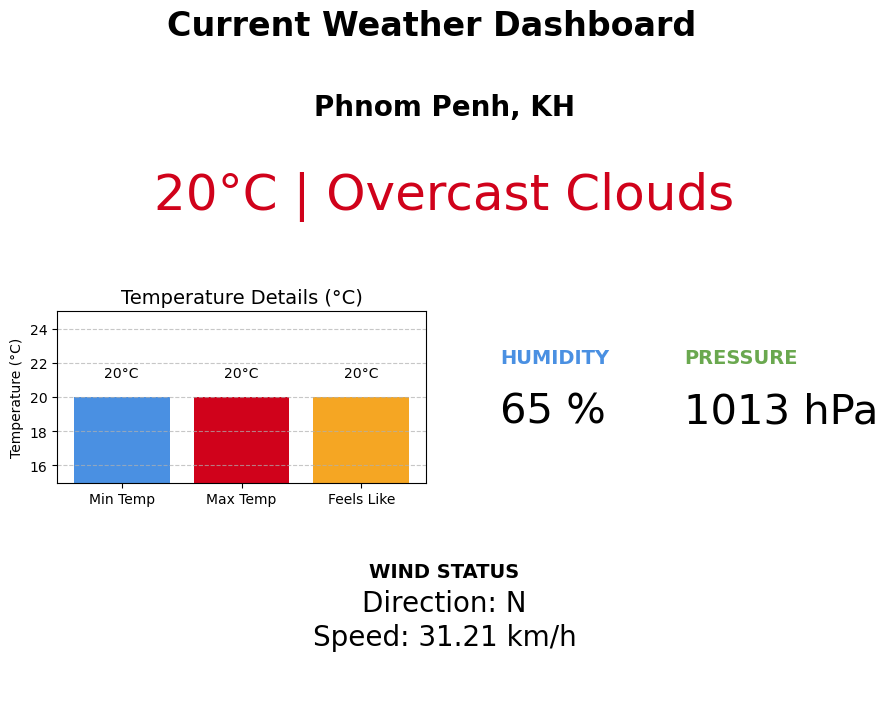

In [9]:
# Test visualization
# city = input("Enter a city where You want to see its weather: ")
dashboard = WeatherDashboard()
# # dashboard.run_dashboard("Phnom Penh")
# dashboard.run_dashboard(city.capitalize())
dashboard._get_city_weather_data("Phnom Penh")
dashboard.run_dashboard("Phnom Penh")

In [ ]:
import requests
from datetime import datetime, timedelta

api_key = "eb8ab4d1cc54eb4db91fe02667b38c7e"

#user input option
def cityoption():
    print("Select the province/city that you want to visit 1-25")
    province =  ["Phnom Penh",
                 "Banteay Meanchey",
                 "Battambang",
                 "Kampong Cham",
                 "Kampong Chhnang",
                 "Kampong Speu",
                 "Kampong Thom",
                 "Kampot",
                 "Kandal",
                 "Kep",
                 "Koh Kong",
                 "Kratié",
                 "Mondulkiri",
                 "Oddar Meanchey",
                 "Pailin",
                 "Preah Vihear",
                 "Preah Sihanouk",
                 "Prey Veng",
                 "Pursat",
                 "Ratanakiri",
                 "Siem Reap",
                 "Stung Treng",
                 "Svay Rieng",
                 "Takeo",
                 "Tbong Khmum"]
    for idx, ProvinceName in enumerate(province, start=1):
        print(f"{idx}. {ProvinceName}")
        
    while True:
        try:
            city_name = int(input("Please input the number of the province/city that you want to visit: "))
            if 1 <= city_name <= len(province):
                start(province[city_name - 1])
                break
            else:
                print(f"Invalid input. Please enter a number between 1 and {len(province)}.")
        except ValueError:
            print("Invalid input. Please enter a valid integer.")


In [ ]:
class API_Forecast_Dashboard:
    
def start(city_name):
    # api_key = "eb8ab4d1cc54eb4db91fe02667b38c7e"

    #Get coordinates from city name
    url = f'https://api.openweathermap.org/data/2.5/weather?q={city_name}&appid={api_key}'
    req = requests.get(url)
    data = req.json()

    if data.get("cod") != 200:
        print(f"Error: {data.get('message', 'City not found')}")
        return

    lat = data['coord']['lat']
    lon = data['coord']['lon']
    city_display = data['name']

    #Get 7-day forecast via One Call API 3.0
    url2 = f"https://api.openweathermap.org/data/3.0/onecall?lat={lat}&lon={lon}&exclude=current,minutely,hourly,alerts&units=metric&appid={api_key}"
    req2 = requests.get(url2)
    data2 = req2.json()
    if 'daily' not in data2:
        print("Error fetching forecast data.")
        return

    daily = data2['daily'][:7]  # Only first 7 days

    # Header
    print(f"7-DAY WEATHER FORECAST FOR {city_display.upper()}")
    print("-" * 110)
    print(f"{'Date':<12} {'Max Temp':<10} {'Min Temp':<10} {'Mean Temp':<11} {'Rain':<8} {'Max Wind':<12} {'Max Gust':<12} {'Wind Dir':<10} {'Weather':<20}")
    print("-" * 110)

    for day in daily:
        dt = datetime.fromtimestamp(day['dt']) + timedelta(days=1)  # Adjust if needed
        date_str = dt.strftime("%Y-%m-%d")

        max_temp = round(day['temp']['max'], 1)
        min_temp = round(day['temp']['min'], 1)
        # Mean = average of all temp points (or approx from day/eve/morn/night)
        mean_temp = round((day['temp']['day'] + day['temp']['eve'] + day['temp']['morn'] + day['temp']['night']) / 4, 1)

        rain = day.get('rain', 0)
        rain_str = f"{rain:.1f}mm" if rain > 0 else "0.0mm"

        wind_speed = day['wind_speed'] * 3.6  # m/s → km/h
        wind_gust = day.get('wind_gust', wind_speed) * 3.6
        max_wind = round(wind_speed, 1)
        max_gust = round(wind_gust, 1)

        wind_dir_deg = day['wind_deg']
        directions = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE", "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
        wind_dir = directions[int((wind_dir_deg + 11.25) // 22.5) % 16]

        weather_main = day['weather'][0]['main']
        weather_desc = day['weather'][0]['description'].capitalize()
        #weather_str = f"{weather_main} {weather_desc}"

        if "rain" in weather_main.lower():
            icon = "Light Rain"
        elif "cloud" in weather_main.lower():
            icon = "Partly Cloudy" if "few" in weather_desc or "scattered" in weather_desc else "Cloudy"
        elif weather_main == "Clear":
            icon = "Sunny"
        else:
            icon = weather_desc.capitalize()

        print(f"{date_str:<12} {max_temp:>6}°C{'':<3} {min_temp:>6}°C{'':<3} {mean_temp:>6}°C{'':<4} "
              f"{rain_str:<8} {max_wind:>6}km/h{'':<4} {max_gust:>6}km/h{'':<4} {wind_dir:>3}° {wind_dir:<5} {icon:<20}")

    # print("-" * 110)
# cityoption()
display(start("Phnom Penh"))

_IncompleteInputError: incomplete input (2457701714.py, line 2)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import requests 
from requests.exceptions import HTTPError, RequestException
from datetime import datetime, timedelta
import math
import matplotlib.dates as mdates

# --- GLOBAL API PLACEHOLDERS AND CONFIGURATION ---
# IMPORTANT: Replace "YOUR_ACTUAL_API_KEY_HERE" with your OpenWeatherMap API key
API_KEY = "YOUR_ACTUAL_API_KEY_HERE" 
BASE_GEO_URL = "https://api.openweathermap.org/data/2.5/weather" # Used to get coordinates from city name
BASE_ONECALL_URL = "https://api.openweathermap.org/data/3.0/onecall" # Used for 7-day forecast

# --- MOCK 7-DAY API RESPONSES (Retained for Adapter Demo) ---
MOCK_FORECAST_RESPONSES = {
    'API_PROVIDER_A': {
        'location_name': 'London',
        'dailyForecast': [
            {'date_time': '2025-12-01T12:00:00Z', 'temp_c': {'avg': 8.5}, 'precip_mm': 5.2, 'desc': 'Showers'},
            {'date_time': '2025-12-02T12:00:00Z', 'temp_c': {'avg': 10.1}, 'precip_mm': 0, 'desc': 'Clear Sky'},
            {'date_time': '2025-12-03T12:00:00Z', 'temp_c': {'avg': 7.9}, 'precip_mm': 1.1, 'desc': 'Light Rain'},
            {'date_time': '2025-12-04T12:00:00Z', 'temp_c': {'avg': 6.8}, 'precip_mm': 0, 'desc': 'Cloudy'},
            {'date_time': '2025-12-05T12:00:00Z', 'temp_c': {'avg': 9.3}, 'precip_mm': 10.0, 'desc': 'Heavy Rain'},
            {'date_time': '2025-12-06T12:00:00Z', 'temp_c': {'avg': 11.0}, 'precip_mm': 0, 'desc': 'Sunny Intervals'},
            {'date_time': '2025-12-07T12:00:00Z', 'temp_c': {'avg': 7.2}, 'precip_mm': 0, 'desc': 'Slight Snowfall'},
        ],
        'unit': 'C'
    },
    'API_PROVIDER_B': {
        'city': 'Paris',
        'days_data': [
            {'timestamp_ms': 1733076000000, 't_avg_f': 48, 'weather_summary': 'Sunny'},
            {'timestamp_ms': 1733162400000, 't_avg_f': 45, 'weather_summary': 'Moderate Rain'},
            {'timestamp_ms': 1733248800000, 't_avg_f': 40, 'weather_summary': 'Light Snow'},
            {'timestamp_ms': 1733335200000, 't_avg_f': 42, 'weather_summary': 'Few Clouds'},
            {'timestamp_ms': 1733421600000, 't_avg_f': 47, 'weather_summary': 'Mist'},
            {'timestamp_ms': 1733508000000, 't_avg_f': 49, 'weather_summary': 'Heavy Rain'},
            {'timestamp_ms': 1733594400000, 't_avg_f': 51, 'weather_summary': 'Overcast'},
        ],
        'unit': 'F'
    }
}

# --- Utility Functions (For Adaptation) ---

def c_to_f(c):
    """Converts Celsius to Fahrenheit."""
    return (c * 9/5) + 32

def f_to_c(f):
    """Converts Fahrenheit to Celsius."""
    return (f - 32) * 5/9

def check_precipitation(conditions):
    """Generic function to determine if the weather status implies rain or snow."""
    lower_case_conditions = conditions.lower()
    return 'rain' in lower_case_conditions or 'showers' in lower_case_conditions or 'snow' in lower_case_conditions

# --- Data Adapter Functions (MOCK) ---

def adapt_api_a(raw_data):
    """Adapter for API_PROVIDER_A (Metric/C)."""
    city_name = raw_data.get('location_name', 'Unknown City (Mock A)')
    return [
        {
            'date': datetime.fromisoformat(day['date_time'].replace('Z', '+00:00')),
            'avg_temp': day['temp_c']['avg'],
            'is_rainy': check_precipitation(day['desc']),
            'status': day['desc'],
            'source_unit': raw_data['unit'],
            'city': city_name
        }
        for day in raw_data['dailyForecast']
    ]

def adapt_api_b(raw_data):
    """Adapter for API_PROVIDER_B (Imperial/F)."""
    city_name = raw_data.get('city', 'Unknown City (Mock B)')
    return [
        {
            'date': datetime.fromtimestamp(day['timestamp_ms'] / 1000),
            'avg_temp': day['t_avg_f'],
            'is_rainy': check_precipitation(day['weather_summary']),
            'status': day['weather_summary'],
            'source_unit': raw_data['unit'],
            'city': city_name
        }
        for day in raw_data['days_data']
    ]

# --- Data Adapter Function (LIVE OpenWeatherMap) ---

def adapt_openweathermap_daily(daily_data, city_name):
    """
    Adapter for raw daily forecast data from OpenWeatherMap One Call API.
    Converts to the standardized format (Metric/C source unit).
    """
    standardized_forecast = []
    
    # We only take the first 7 days from the raw data
    for day in daily_data[:7]:
        dt = datetime.fromtimestamp(day['dt'])
        
        # Calculate mean temperature from available fields
        mean_temp = (day['temp']['day'] + day['temp']['eve'] + day['temp']['morn'] + day['temp']['night']) / 4
        
        # Determine if rainy based on the primary weather status
        weather_main = day['weather'][0]['main']
        weather_desc = day['weather'][0]['description'].capitalize()

        # Check precipitation based on the user's logic
        is_rainy_status = "rain" in weather_main.lower() or "snow" in weather_main.lower()
        
        # Use user's logic for status mapping (Clear -> Sunny, etc.)
        if "rain" in weather_main.lower():
            icon = "Light Rain"
        elif "cloud" in weather_main.lower():
            icon = "Partly Cloudy" if "few" in weather_desc.lower() or "scattered" in weather_desc.lower() else "Cloudy"
        elif weather_main == "Clear":
            icon = "Sunny"
        else:
            icon = weather_desc.capitalize()


        standardized_forecast.append({
            'date': dt,
            'avg_temp': mean_temp,
            'is_rainy': is_rainy_status,
            'status': icon,
            'source_unit': 'C', # OWM daily forecast uses Kelvin by default but we ask for 'metric'
            'city': city_name
        })
        
    return standardized_forecast

# --- Base Class (Retained for inheritance) ---
class WeatherDashboard:
    """Base class structure for weather dashboards."""
    
    def __init__(self):
        self.data = None

    def _degrees_to_cardinal(self, d):
        dirs = ["N", "NNE", "NE", "ENE", "E", "ESE", "SE", "SSE",
                "S", "SSW", "SW", "WSW", "W", "WNW", "NW", "NNW"]
        ix = round(d / (360. / len(dirs)))
        return dirs[ix % len(dirs)]

    def render_dashboard(self):
        raise NotImplementedError("Base class method should be overridden by subclass.")

# --- Inherited and Adapted Class for 7-Day Forecast (Updated) ---

class ForecastDashboard(WeatherDashboard):
    """
    Handles 7-day forecast data from Mocks or Live API via the Adapter Pattern 
    and visualizes it with Matplotlib.
    """
    
    def __init__(self, source_input):
        """
        Initializes the dashboard, loading data either from a mock provider 
        name (str) or a live city name (str).
        """
        super().__init__()
        self.api_name = None
        self.city_name = "N/A"
        self.display_unit = 'C' # Default display unit
        
        if source_input in MOCK_FORECAST_RESPONSES:
            self.api_name = source_input
            self.data = self._fetch_and_adapt_mock(source_input)
        elif isinstance(source_input, str):
            self.city_name = source_input
            self.data = self._fetch_and_adapt_live(source_input)
        else:
            print("ERROR: Invalid input. Must be a mock provider name or a city name.")
            self.data = []
            
        if self.data and self.data[0]['city']:
            self.city_name = self.data[0]['city']


    # --- New Live Data Fetching Logic (Based on user's `start` function) ---
    
    def _get_live_weather_data(self, city_name):
        """
        Fetches coordinates and then the 7-day daily forecast data from OpenWeatherMap.
        """
        if API_KEY == "YOUR_ACTUAL_API_KEY_HERE" or not API_KEY:
            print("CRITICAL ERROR: API_KEY is not set. Please update the global variable.")
            return None, None

        print(f"INFO: Attempting to fetch live forecast for {city_name}...")
        
        # 1. Get coordinates from city name (using the 2.5/weather endpoint as a geocoder)
        try:
            params = {'q': city_name, 'appid': API_KEY, 'units': 'metric'}
            req = requests.get(BASE_GEO_URL, params=params)
            req.raise_for_status()
            data = req.json()
            
            lat = data['coord']['lat']
            lon = data['coord']['lon']
            city_display = data['name']
        except HTTPError as e:
            if e.response.status_code == 404:
                print(f"ERROR: City '{city_name}' not found.")
            else:
                print(f"ERROR: Geo-location request failed: {e}")
            return None, None
        except RequestException as e:
            print(f"ERROR: Network error during Geo-location lookup: {e}")
            return None, None
        
        # 2. Get 7-day forecast via One Call API 3.0
        try:
            # exclude current, minutely, hourly, alerts to save bandwidth
            params2 = {
                'lat': lat, 
                'lon': lon, 
                'appid': API_KEY, 
                'units': 'metric', 
                'exclude': 'current,minutely,hourly,alerts'
            }
            req2 = requests.get(BASE_ONECALL_URL, params=params2)
            req2.raise_for_status()
            data2 = req2.json()

            if 'daily' not in data2:
                print("Error fetching forecast data: 'daily' key missing.")
                return None, None
            
            return data2['daily'], city_display

        except HTTPError as e:
            print(f"ERROR: One Call forecast request failed: {e}")
            return None, None
        except RequestException as e:
            print(f"ERROR: Network error during One Call forecast: {e}")
            return None, None
        
    def _fetch_and_adapt_live(self, city_name):
        """Fetches live data and applies the OpenWeatherMap adapter."""
        daily_data, display_city = self._get_live_weather_data(city_name)
        
        if daily_data:
            print(f"INFO: Adapting live data for {display_city}...")
            # Use the new dedicated adapter function
            return adapt_openweathermap_daily(daily_data, display_city)
        return []

    def _fetch_and_adapt_mock(self, api_name):
        """Fetches mock data and applies the mock adapter."""
        raw_data = MOCK_FORECAST_RESPONSES.get(api_name)
        if not raw_data:
            print(f"ERROR: Unknown mock API provider '{api_name}'.")
            return []

        print(f"INFO: Adapting mock data from {api_name}...")
        
        if api_name == 'API_PROVIDER_A':
            return adapt_api_a(raw_data)
        elif api_name == 'API_PROVIDER_B':
            return adapt_api_b(raw_data)
        return []

    # --- Reusable Visualization Method (Forecast Plot) ---

    def _plot_forecast_summary(self, ax):
        """
        Plots the 7-day forecast data: temperature line, rain indicators, and status.
        This method is reusable by both live and mock data sources.
        """
        if not self.data:
            ax.text(0.5, 0.5, "No forecast data available.", ha='center', va='center', fontsize=14)
            return

        dates = [day['date'] for day in self.data]
        temps = []
        
        # Apply conversion logic based on current display_unit
        unit_symbol = f"°{self.display_unit}"
        
        for day in self.data:
            temp = day['avg_temp']
            source_unit = day['source_unit']

            if self.display_unit == 'F' and source_unit == 'C':
                temp = c_to_f(temp)
            elif self.display_unit == 'C' and source_unit == 'F':
                # Only needed if source_unit was F (like Mock B), not OWM live data
                temp = f_to_c(temp)
            
            temps.append(round(temp))
            
        # Plot the temperature line 
        ax.plot(dates, temps, marker='o', linestyle='-', color='#3b82f6', linewidth=2, markersize=8, label=f'Avg Temp ({unit_symbol})')

        # Add temperature labels and status annotations
        for d, t, day_data in zip(dates, temps, self.data):
            # Annotate temperature
            ax.text(d, t + 0.5, f'{t}{unit_symbol}', ha='center', va='bottom', fontsize=10, color='#1e40af', fontweight='bold')
            
            # Annotate status/rain
            if day_data['is_rainy']:
                color = '#0369a1'
                # Add a marker at the bottom to indicate rain
                ax.scatter(d, min(temps) - 2, marker='^', s=100, color='#60a5fa', edgecolors=color, zorder=5)
            else:
                color = '#22c55e'
            
            # Annotate weather status (using the condition description)
            ax.text(d, t - 1.5, day_data['status'], ha='center', va='top', fontsize=8, color=color, rotation=15)


        # Configure axes and title
        ax.set_title(f"7-Day Forecast for {self.city_name}", fontsize=16, fontweight='bold', color='#1e3a8a')
        ax.set_ylabel(f'Temperature ({unit_symbol})', fontsize=12, color='#374151')
        ax.grid(axis='y', linestyle='--', alpha=0.6)
        
        # Format the x-axis to show weekdays
        date_format = mdates.DateFormatter('%a, %b %d')
        ax.xaxis.set_major_formatter(date_format)
        plt.xticks(rotation=45, ha='right')
        
        # Set limits to comfortably fit all labels
        min_temp_for_lim = min(temps) if temps else 0
        max_temp_for_lim = max(temps) if temps else 10
        ax.set_ylim(min_temp_for_lim - 8, max_temp_for_lim + 5)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

    # --- Overridden Main Execution Method ---

    def render_dashboard(self):
        """Generates and displays the complete Matplotlib forecast plot."""
        if not self.data:
            print("ERROR: Cannot render dashboard. Data is missing.")
            return

        # Simple figure setup suitable for a single plot visualization
        fig = plt.figure(figsize=(12, 6))
        fig.suptitle(f"Weather Forecast Adapter Demo: {self.city_name} ({'Live Data' if not self.api_name else 'Mock Data'})", fontsize=20, fontweight='bold')
        ax = fig.add_subplot(111)

        self._plot_forecast_summary(ax)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

# --- Demonstration ---
if __name__ == '__main__':
    # NOTE: To run live data demos, you must replace "YOUR_ACTUAL_API_KEY_HERE"
    # with a valid OpenWeatherMap API key at the top of the file.

    # --- DEMO A: Live API Data (Requires API Key) ---
    print("\n--- DEMO A: Live Data from OpenWeatherMap (e.g., Phnom Penh) ---")
    if API_KEY != "YOUR_ACTUAL_API_KEY_HERE":
        # Using a city from the user's list
        live_dashboard = ForecastDashboard('Phnom Penh') 
        live_dashboard.render_dashboard()
        
        # Demonstrate conversion (e.g., view OWM data in Fahrenheit)
        print("\n--- DEMO A (Conversion): Live Data in Fahrenheit ---")
        live_dashboard.display_unit = 'F'
        live_dashboard.render_dashboard()
    else:
        print("Skipping Live Data Demo: API key is not configured.")

    # --- DEMO B: Using API_PROVIDER_A (Metric Mock Source) ---
    print("\n--- DEMO B: Using API_PROVIDER_A (Metric Mock Source) ---")
    dashboard_a = ForecastDashboard('API_PROVIDER_A')
    dashboard_a.render_dashboard()
    
    # --- DEMO C: Using API_PROVIDER_B (Imperial Mock Source) ---
    print("\n--- DEMO C: Using API_PROVIDER_B (Imperial Mock Source) ---")
    dashboard_b = ForecastDashboard('API_PROVIDER_B')
    dashboard_b.render_dashboard()